In [153]:
import random
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi, log10, log2, sqrt, cos, sin
from scipy.optimize import minimize, minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
from distributions import southernUtah, saltLakeCity, sanDiego, twinCities, oneFarOneClose

## Parameters
- $r$ = radius of the UAV's flight path
    -  $r_\text{min}$ = minimum radius of the UAV's flight path
    -  $r_\text{max}$ = maximum radius of the UAV's flight path
- $D$ = location of user distribution along x-axis
- $r_\text{D}$ = radius of user distribution
- $c_\text{x}$ = x-coordinate of the center point of the UAV's flight path
    - $c_\text{xmin}$ = minimum which $c_\text{x}$ can take
    - $c_\text{xmax}$ = maximum which $c_\text{x}$ can take
- $c_\text{y}$ = y-coordinate of the center point of the UAV's flight path
    - $c_\text{ymin}$ = minimum which $c_\text{y}$ can take
    - $c_\text{ymax}$ = maximum which $c_\text{y}$ can take
- $v$ = speed of the UAV
- $T$ = time it takes for the drone to complete one flight circle
    - $T_\text{max}$ = time it takes the drone to complete maximum flight circle
- $T_\text{C}$ = length of each timeslot
- $N$ = number of time slots
    - $N_\text{max}$ = number of timeslots in maximum flight circle
- $M$ = number of users that the UAV can serve simultaneously
- $K$ = total number of users = $M\cdot N$
    - $K_\text{max}$ = maximum number of users = $M\cdot N_\text{max}$
- $H$ = height of the UAV's flight path
- $P^\text{A}_\text{tx}$ = UAV transmission power
- $P^\text{U}_\text{tx}$ = user transmission power
- $G_\text{T}$ = antenna gain at transmitter
- $G_\text{R}$ = antenna gain at receiver
- $B$ = total bandwidth
- $N_\text{0}$ = noise power
- $f$ = signal frequency
- $\lambda$ = signal wavelength

In [154]:
r_min = 1000 # meters
r_max = 5000 # meters
D = 15000 # meters
rD = 4000 # meters
c_xmin = -10000 # meters
c_xmax = 10000 # meters
c_ymin = -10000
c_ymax = 10000
v = 50 # meters/second
T_max = (2*pi*r_max)/v # seconds
TC = 1 # seconds
N_max = int(T_max // TC) # time slots
M = 2 # users
K = N_max*M # users
H = 100 # meters
PAtx = 1 # watts
PUtx = 0.07 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots.

In [155]:
def generate_users(num_users, distribution='uniform', seed=324):
    random.seed(seed)
    rng = np.random.default_rng(324)
    
    users = []
    if (distribution == 'uniform'):
        for _ in range(num_users):
            r = rD * sqrt(random.random())
            theta = random.uniform(0, 2*pi)
            x = D + r * cos(theta)
            y = r * sin(theta)
    
            users.append((x, y))
    elif (distribution == 'skewed-normal'):
        x_mean = D + 5000
        y_mean = 0
        std_dev = 1000
        
        while (len(users) < num_users):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))
    elif (distribution == 'two-skewed-normal'):
        x_mean = D + 5000
        y_mean = 0
        std_dev = 1000
        
        while (len(users) < num_users*0.5):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))
        
        x_mean = D
        y_mean = -5000
        std_dev = 1000

        while (len(users) < num_users):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))

                         
    random.shuffle(users)
    return users


users = generate_users(K, distribution='two-skewed-normal')
print(len(users))
print(K)

1256
1256


## Plot Users
This code plots the user coordinates to verify that the distribution is working correctly

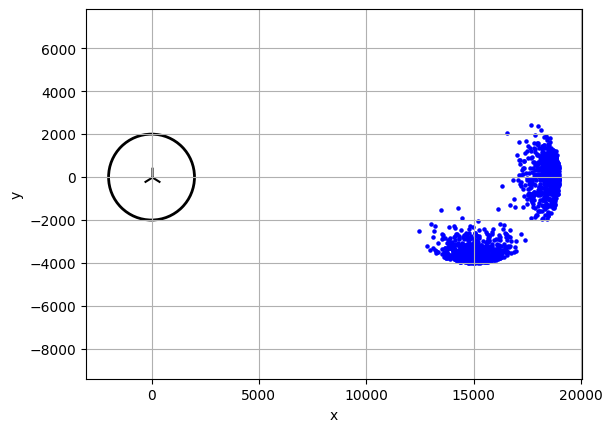

In [156]:
xs, ys = zip(*users)

plt.scatter(xs, ys, c='b', marker='o', s=5)

plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")

ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)

plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)

plt.axis("equal")  # equal scaling

plt.show()

## UAV Trajectory
The UAV’s trajectory can be considered a discrete sequence of positions, each one a function of the flight path radius $r$ and the flight path center point $(c_\text{x}, c_\text{y}, H)$. If there are $N$ timeslots indexed $0\dots N-1$, then the UAV’s position during timeslot $n$ is given by 
$$\mathbf{w}_n^\text{A}(r,c_\text{x}, c_\text{y}) = \left[c_\text{x} + r\cos\left(\frac{2\pi n}{N}\right),c_\text{y}+r\sin\left(\frac{2\pi n}{N}\right),H\right]$$


In [157]:
def wA(n, r, cx, cy):
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots
    
    x = cx + r*cos( (2*pi*n) / N )
    y = cy + r*sin( (2*pi*n) / N )
    z = H
    return (x, y, z)

## User-to-UAV Power
We assume users with a fixed transmission power $P^\text{U}_\text{tx}$. Let $n$ denote the timeslot index with respect to the UAV’s discrete positions along its trajectory, let $\lambda$ denote the wavelength of the signal, and let $G_\text{T}$, $G_\text{R}$ denote the antenna gain at the user and UAV respectively. The power of the signal received by the UAV from the user is then given as
$$P^\text{A}_{n,k} = P^\text{U}_\text{tx}\cdot G_\text{T}G_\text{R}\left(\frac{\lambda}{4\pi \cdot ||\mathbf{w}^\text{A}_n - \mathbf{w}^\text{U}_k||}\right)^2$$

In [158]:
def PA(n, r, cx, cy, wU):
    wAn = wA(n, r, cx, cy)

    dist = sqrt((wAn[0] - wU[0])**2
        + (wAn[1] - wU[1])**2
        + (wAn[2])**2)
    
    return PUtx * GT * GR * (WAVELENGTH / (4*pi*dist))**2

## UAV-to-BS Power
Let $P^\text{A}_\text{tx}$ be the UAV transmission power. It follows that the power of the signal received by the base station during the
$n$th timeslot is expressed
$$P^\text{B}_n(r, c) = P^\text{A}_\text{tx}\cdot G_\text{T}G_\text{R}\left(\frac{\lambda}{4\pi\cdot||\mathbf{w}^\text{A}_n||}\right)^2$$

In [159]:
def PB(n, r, cx, cy):
    wAn = wA(n, r, cx, cy)

    dist = sqrt(wAn[0]**2 + wAn[1]**2 + wAn[2]**2)

    return PAtx * GT * GR * (WAVELENGTH / (4*pi*dist))**2

## User-to-UAV SNR
Let $N_0$ be the noise power over the entire bandwidth. In the user-to-UAV link, there are $M$ users transmitting simultaneously to the UAV, the channel for a single user experiences the noise with power $N_0/M$. Thus, the signal-to-noise ratio of the link from the $k$th user to the UAV during the $n$th timeslot can be expressed as
$$\text{SNR}^\text{UA}_{n,k}(r, c) = \frac{P^\text{A}_{n,k}}{N_0/M}$$

In [160]:
def SNRUA(n, r, cx, cy, wU):
    return PA(n, r, cx, cy, wU) / (N0 / M)

## UAV-to-BS SNR
The signal-to-noise ratio of the UAV-to-BS link during the $n$th timeslot can be expressed
$$\text{SNR}^\text{AB}_n(r, c) = \frac{P^\text{B}_n}{N_0}$$

In [161]:
def SNRAB(n, r, cx, cy):
    return PB(n, r, cx, cy) / N0

# User-to-UAV SE
The spectral efficiency of the link from the $k$th user to the UAV during the $n$th timeslot is given by
$$\text{SE}^\text{UA}_{n,k}(r, c) = \log_2\left(1 + \text{SNR}^\text{UA}_{n,k}\right)$$

In [162]:
def SEUA(n, r, cx, cy, wU):
    return log2(1 + SNRUA(n, r, cx, cy, wU))

## UAV-to-BS SE
The spectral efficiency of the link from the UAV to the base station during the $n$th timeslot is given as
$$\text{SE}^\text{AB}_n(r, c) = \log_2\left(1 + \text{SNR}^\text{AB}_n\right)$$

In [163]:
def SEAB(n, r, cx, cy):
    return log2(1 + SNRAB(n, r, cx, cy))

## Mean SE (objective function)
We define $\alpha$ as the proportion of each timeslot reserved for user-to-UAV transmission. The proportion of the timeslot reserved for UAV-to-BS transmission is $1-\alpha$. 

The average achievable spectral efficiency of the relay system over the timeslots is then given as
$$\overline{\text{SE}}(\alpha, r, c) = \frac{1}{N}\sum_{n=0}^N \min\left[\alpha \cdot \frac{1}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [164]:
def meanSE(alpha, r, cx, cy):
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots
    
    total_se = 0
    user_index = 0
    for n in range(N):
        ua_se = 0

        for user_index in range(user_index, user_index + M):
            ua_se += SEUA(n, r, cx, cy, users[user_index])

        ua_se *= (alpha / M)

        ab_se = SEAB(n, r, cx, cy)
        ab_se *= (1 - alpha)
        
        total_se += min(ua_se, ab_se)

    return total_se / N

## Min SE (objective function)
Equation for minSE is:
$$\min_{n\in N}\left[\alpha\cdot \min_{k\in \mathcal{U_n}}\left( \text{SE}^\text{UA}_{n,k}\right)\;,\;(1-\alpha)\cdot \text{SE}^\text{AB}_n\right]$$

In [165]:
def minSE(alpha, r, cx, cy):
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots

    min_throughput = np.inf
    user_index = 0
    for n in range(N):
        min_ua = np.inf
        
        for user_index in range(user_index, user_index + M):
            min_ua = min(min_ua, SEUA(n, r, cx, cy, users[user_index]))
        
        min_ua *= alpha
        min_ab = (1-alpha)*SEAB(n, r, cx, cy)


        min_throughput = min(min_throughput, min_ua, min_ab)

    return min_throughput

## Mean SE with Smooth Min
Here I define the same objective function, but using the the $\min$ function is replaced with a Huber-like softmin. If we let $\epsilon>0$ smooth the corner, this is defined:
$$\min(a, b) \approx \frac{1}{2}\left(a + b - \sqrt{(a - b)^2 + \epsilon}\right)$$

To rewrite the objective function, we first define
$$a_n = \frac{\alpha}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}$$
$$b_n = (1-\alpha)\cdot\text{SE}^\text{AB}_n$$

The softmin-ed objective function is then given as:
$$\overline{\text{SE}}(\alpha,r,c) = \frac{1}{N}\sum_{n=1}^N \frac{1}{2}\left(a_n + b_n - \sqrt{(a_n-b_n)^2 + \epsilon}\right)$$

In [166]:
def smooth_meanSE(alpha, r, cx, cy):
    epsilon = 0.5
    
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots
    
    total_se = 0
    user_index = 0
    for n in range(N):
        ua_se = 0

        for user_index in range(user_index, user_index + M):
            ua_se += SEUA(n, r, cx, cy, users[user_index])

        ua_se *= (alpha / M)

        ab_se = SEAB(n, r, cx, cy)
        ab_se *= (1 - alpha)
        
        total_se += 0.5 * (ua_se + ab_se - sqrt((ua_se - ab_se)**2 + epsilon))

    return total_se / N

## Baselines
Here I define two baselines to see how much improvement the optimizations are providing us. The two baselines are
1. Running 1000 random trials with $\alpha=0.5$, a random $c\in[0,2*D]$, and a random $r\in[r_\text{min}, r_\text{max}]$
2. MeanSE with $\alpha=0.5$, $c=D/2$, and $r=(r_\text{min}+r_\text{max})/2$

In [167]:
def mean_baselines(seed=324):
    random.seed(seed)
    
    rand_total = 0

    for i in range(1000):
        rand_total += meanSE(0.5, random.uniform(r_min, r_max), random.uniform(c_xmin, c_xmax), random.uniform(c_ymin, c_ymax))

    rand_total /= 1000

    return (rand_total, meanSE(0.5, (r_min+r_max)/2, (c_xmin + c_xmax)/2, (c_ymin + c_ymax)/2))

def min_baselines(seed=324):
    random.seed(seed)
    
    rand_total = 0

    for i in range(1000):
        rand_total += minSE(0.5, random.uniform(r_min, r_max), random.uniform(c_xmin, c_xmax), random.uniform(c_ymin, c_ymax))

    rand_total /= 1000

    return (rand_total, minSE(0.5, (r_min+r_max)/2, (c_xmin + c_xmax)/2, (c_ymin + c_ymax)/2))

a, b = mean_baselines()

print(f'minSE with random r, cx, cy: {a}')
print(f'minSE with centered r, cx, cy: {b}')

minSE with random r, cx, cy: 1.0486185954001273
minSE with centered r, cx, cy: 1.0317175344655278


## $\alpha$ Optimizer
### For meanSE
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $c$. Define for each timeslot
$$a_n := \frac{1}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}(r,c)$$
and
$$b_n := \text{SE}^\text{AB}_n(r,c).$$
The two pieces will be equal at
$$\alpha = \frac{b_n}{a_n + b_n} = t_n.$$
Then the full objective function is
$$f(\alpha)=\frac{1}{N}\sum_{n=0}^{N-1}\begin{cases}\alpha\cdot a_n & ,\alpha \leq t_n\\ (1-\alpha)\cdot b_n & , \alpha > t_n\end{cases}$$
the derivative is
$$f'(\alpha) = \frac{1}{N}\sum_{n=0}^{N-1}\begin{cases}a_n & ,\alpha\leq t_n\\ -b_n & ,\alpha>t_n\end{cases}$$

Key facts:
- $\min(a_n, b_n)$ is concave (minimum of two affine functions)
- $f$ is concave because $\min(a_n, b_n)$ is concave
- Because $f$ is concave, it's maximum will lie at a point where the sign of the derivative changes (one of the $t_n$s) or a boundary $\alpha = 0$ or $\alpha = 1$
- Maybe need to check points where derivative = 0, but idk where that happens
### For minSE
Define for each timeslot
$$a_n := \min_{k\in\mathcal{U}_n}\left(\text{SE}^\text{UA}_{n,k}\right)$$
and
$$b_n := \text{SE}^\text{AB}_n.$$
Then the two pieces will be equal at
$$\alpha = \frac{b_n}{a_n + b_n} = t_n$$
The full objective function is
$$f(\alpha) = \begin{cases}
\alpha\cdot a_n & ,\alpha\leq t_n\\
(1-\alpha)\cdot b_n & ,\alpha > t_n
\end{cases}$$
and the derivative is
$$f'(\alpha) = \begin{cases}
a_n & , \alpha \leq t_n\\
-b_n & , \alpha > t_n
\end{cases}$$ 
Key facts
- $a_n$ is concave (minimum of an affine function)
- $\min\left(a_n, b_n\right)$ is concave (minimum of two affine functions)
- $f$ is concave because $\min(a_n, b_n)$ is concave
- Because $f$ is concave, it's maximum will lie at a point where the sign of the derivative changes (one of the $t_n$s) or a boundary $\alpha = 0$ or $\alpha = 1$
- Maybe need to check points where derivative = 0, but idk where that happens

In [168]:
def mean_maximizeAlpha(r, cx, cy):
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots
    
    tn_list = []
    user_index = 0
    for n in range(N):
        an = 0
        for user_index in range(user_index, user_index + M):
            an += SEUA(n, r, cx, cy, users[user_index])

        an /= M

        bn = SEAB(n, r, cx, cy)

        tn_list.append( bn / (an + bn) )
        
    tn_list.append(1)
    
    opt_alpha = 0
    max_meanSE_val = meanSE(0, r, cx, cy)

    for tn in tn_list:
        meanSE_val = meanSE(tn, r, cx, cy)

        if (meanSE_val > max_meanSE_val):
            opt_alpha, max_meanSE_val = tn, meanSE_val

    return opt_alpha

def min_maximizeAlpha(r, cx, cy):
    T = (2 * pi * r) / v # period
    N = int(T // TC)     # number of timeslots
    
    tn_list = []
    user_index = 0
    for n in range(N):
        an = np.inf
        for user_index in range(user_index, user_index + M):
            an = min(an, SEUA(n, r, cx, cy, users[user_index]))

        bn = SEAB(n, r, cx, cy)

        tn_list.append( bn / (an + bn) )
        
    tn_list.append(1)
    
    opt_alpha = 0
    max_minSE = minSE(0, r, cx, cy)

    for tn in tn_list:
        minSE_val = minSE(tn, r, cx, cy)

        if (minSE_val > max_minSE):
            opt_alpha, max_minSE = tn, minSE_val

    return opt_alpha

## Block Optimizer With Powell's for $\alpha$, $r$, $c$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, and $c$. First, the optimal $\alpha$ is found for our initial $r$ and $c$. Then, $r$ and $c$ are optimized for the optimal $\alpha$. This process repeats until the objective function is improving by less than $\epsilon = 0.001$.

iteration 0
Optimization terminated successfully.
iteration 1
Optimization terminated successfully.
iteration 2
Optimization terminated successfully.
iteration 3
Optimization terminated successfully.
iteration 4
Optimization terminated successfully.
iteration 5
Optimization terminated successfully.
iteration 6
Optimization terminated successfully.
iteration 7
Optimization terminated successfully.
iteration 8
Optimization terminated successfully.
iteration 9
Optimization terminated successfully.
iteration 10
Optimization terminated successfully.
iteration 11
Optimization terminated successfully.
iteration 12
Optimization terminated successfully.
iteration 13
Optimization terminated successfully.
iteration 14
Optimization terminated successfully.
iteration 15
Optimization terminated successfully.
iteration 16
Optimization terminated successfully.
iteration 17
Optimization terminated successfully.
iteration 18
Optimization terminated successfully.
iteration 19
Optimization terminated succ

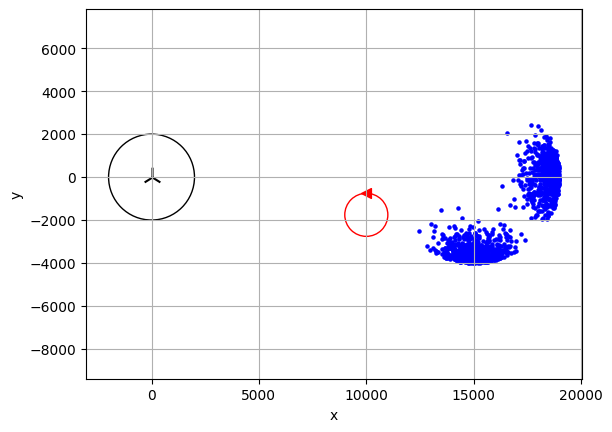

In [169]:
def mean_objective(params, alpha):
    r, cx, cy = params
    return -meanSE(alpha, r, cx, cy)

def mean_smooth_objective(params, alpha):
    r, cx, cy = params
    return -smooth_meanSE(alpha, r, cx, cy)

def min_objective(params, alpha):
    r, cx, cy = params
    return -minSE(alpha, r, cx, cy)

bounds = [(r_min, r_max), (c_xmin, c_xmax), (c_ymin, c_ymax)]

def mean_block_descent(r_init, c_xinit, c_yinit, method='powell'):
    r = r_init
    cx = c_xinit
    cy = c_yinit
    alpha = 0.5
    
    delta = np.inf
    se = 0

    it = 0
    
    while (delta > 1e-3):
        print(f'iteration {it}')
        it += 1
        
        alpha = mean_maximizeAlpha(r, cx, cy)
        
        
        if (method == 'powell'):
            result = minimize(
                mean_objective,
                [r,cx,cy],
                args=(alpha),
                method='Powell',
                bounds=bounds,
                options={
                    'maxiter':1000,
                    'xtol':1e-3,
                    'ftol':1e-3
                }
            )
        elif (method == 'l-bfgs-b'):
            result = minimize(
                mean_smooth_objective,
                [r, cx, cy],
                args=(alpha,),             # must be a tuple
                method='L-BFGS-B',
                bounds=bounds,
                options={
                    'maxiter': 1000,
                    'ftol': 1e-7,          # function tolerance
                    'gtol': 1e-6           # gradient tolerance
                }
            )
        print(result.message)

        r, cx, cy = result.x
        delta = -result.fun - se

        se = -result.fun

    return alpha, r, cx, cy, se

def min_block_descent(r_init, c_xinit, c_yinit):
    r = r_init
    cx = c_xinit
    cy = c_yinit
    alpha = 0.5
    
    delta = np.inf
    se = 0

    it = 0
    while (delta > 1e-3):
        it += 1
        
        alpha = min_maximizeAlpha(r, cx, cy)
        
        result = minimize(
            min_objective,
            [r,cx,cy],
            args=(alpha),
            method='Powell',
            bounds=bounds,
            options={
                'maxiter':1000,
                'xtol':1e-3,
                'ftol':1e-3
            }
        )

        r, cx, cy = result.x
        delta = -result.fun - se

        se = -result.fun

    return alpha, r, cx, cy, se


alpha_opt, r_opt, c_xopt, c_yopt, se_opt = mean_block_descent(1000, 0, 0)

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center: ({c_xopt}, {c_yopt})')
print(f'Max se: {se_opt}')

xs, ys = zip(*users)

plt.scatter(xs, ys, c='b', marker='o', s=5)

plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")

plt.scatter(c_xopt, c_yopt+r_opt, c='r', marker='<', s=50, label="UAV")

ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((c_xopt, c_yopt), radius=r_opt, fill=False, color='red', linewidth=1)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)

plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)

plt.axis("equal")  # equal scaling

plt.show()


## Transmission Power vs. Achievable SE
Here I generate plots for both normal and uniform distributions showing how transmission power affects the achievable SE

In [170]:
def generate_plot(distribution='uniform'):
    gamma_list = np.linspace(1, 10, 100)

    se_list = []
    for gamma in gamma_list:
        _1, _2, _3, se = block_descent(1000, D/2, distribution=distribution, PUtx=gamma*PUtx, PAtx=gamma*PAtx)

        se_list.append(se)

    plt.scatter(gamma_list, se_list, c='b', marker='o', s=5)
    plt.xlabel("gamma")
    plt.ylabel("spectral efficiency")
    plt.axis("equal")  # equal scaling
    plt.show()


    

## Upper Bound (rotary-wing optimizer)
Here I define the necessary functions to find the maximum average spectral efficiency achievable by a rotary-wing UAV. The rotary-wing drone hovers at a height $H$ and we optimize its position along the x-axis, $c$. The rotary-wing UAV relays for $N_\text{max}$ time slots.

In [171]:
def rotary_SEUA(c, wU):
    dist = sqrt((c - wU[0])**2 + wU[1]**2 + H**2)
    PA = PUtx * GT * GR * (WAVELENGTH / (4*pi*dist))**2

    SNR = PA / (N0 / M)

    return log2(1 + SNR)

def rotary_SEAB(c):
    dist = sqrt(c**2 + H**2)
    
    PB = PAtx * GT * GR * (WAVELENGTH / (4*pi*dist))**2

    SNR = PB / N0

    return log2(1 + SNR)

def rotary_meanSE(alpha, c):
    total_se = 0
    user_index = 0

    ab_se = rotary_SEAB(c) * (1 - alpha)

    for n in range(N_max):
        ua_se = 0

        for user_index in range(user_index, user_index + M):
            ua_se += rotary_SEUA(c, users[user_index])

        ua_se *= (alpha / M)

        total_se += min(ua_se, ab_se)

    return total_se / N_max

def rotary_maximizeAlpha(c):
    tn_list = []
    user_index = 0

    bn = rotary_SEAB(c)
    
    for n in range(N_max):
        an = 0
        for user_index in range(user_index, user_index + M):
            an += rotary_SEUA(c, users[user_index])

        an /= M

        tn_list.append( bn / (an + bn) )
        
    tn_list.append(1)
    
    max_alpha = 0
    max_alpha_val = rotary_meanSE(0, c)

    for tn in tn_list:
        tn_val = rotary_meanSE(tn, c)

        if (tn_val > max_alpha_val):
            max_alpha, max_alpha_val = tn, tn_val

    return max_alpha

def optimize_c(c_init):
    alpha = rotary_maximizeAlpha(c_init)

    search_size = 1000
    
    c_vals = np.linspace(c_min, c_max, search_size)
    se_vals = [0 for i in range(search_size)]
    
    best_se = 0
    best_idx = 0
    
    for i in range(search_size):
        se_vals[i] = rotary_meanSE(alpha, c_vals[i])

        if (se_vals[i] > best_se):
            best_se = se_vals[i]
            best_idx = i

    new_cmin, new_cmax, new_cinit = 0, 0, 0
    
    if (best_idx == 0):
        new_cmin = c_vals[0]
        new_cmax = c_vals[1]
        new_cinit = (new_cmin + new_cmax) / 2
    elif (best_idx == search_size-1):
        new_cmin = c_vals[search_size-2]
        new_cmax = c_vals[search_size-1]
        new_cinit = (new_cmin + new_cmax) / 2
    else:
        new_cmin = c_vals[best_idx-1]
        new_cmax = c_vals[best_idx+1]
        new_cinit = c_vals[best_idx]
        

    alpha = rotary_maximizeAlpha(new_cinit, users)

    # result = minimize(
    #     lambda c: -rotary_meanSE(alpha, c, users),
    #     D/2,
    #     bounds=(new_cmin, new_cmax),
    #     method='Powell',
    #     options={
    #         'maxiter':1000,
    #         'xtol':1e-3,
    #         'ftol':1e-3
    #     }
    # )

    result = minimize_scalar(
        lambda c: -rotary_meanSE(alpha, c, users),
        bounds=(new_cmin, new_cmax),
        method='bounded'
    )

    c_opt = result.x
    se_opt = -result.fun
    
    return c_opt, se_opt, result

c_opt, se_opt, _ = optimize_c(D/2)

print(f'Optimal centerpoint: {c_opt}')
print(f'Achievable se: {se_opt}')

NameError: name 'c_min' is not defined

In [ ]:
total = 0
for i in range(1000):
    total += meanSE(0.5, random.randint(500, 2000), random.randint(0, 2*D), users)

print(total /1000)

In [ ]:
c_vals = np.linspace(0, 2*D, 100)
r_vals = np.linspace(1000, 3000, 100)

# Create arrays to hold results
SE_values = np.zeros((len(c_vals), len(r_vals)))

for i, c in enumerate(c_vals):
    for j, r in enumerate(r_vals):
        alpha = maximizeAlpha(r, c, users)
        SE_values[i, j] = meanSE(alpha, r, c, users)

# Create meshgrid for plotting
R, C = np.meshgrid(r_vals, c_vals)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(R, C, SE_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('r')
ax.set_ylabel('c')
ax.set_zlabel('meanSE')
ax.set_title('UAV Optimization Surface')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
generate_users(max_K)